In [ ]:
!pip install pgeocode
!pip install pyproj
!pip install folium

#import geopandas as gpdimport 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyodbc
import pgeocode

import json
import folium
from pyproj import crs
from folium import plugins


In [ ]:
#This function extracts columns from the Date Column and labels them

def add_date_cols(data, date_col, weekday_df, month_df):
    data['Day'] = data[date_col].apply(lambda x: x.day)
    data['Day_of_Week'] = data[date_col].apply(lambda x: x.weekday())
    data['Month'] = data[date_col].apply(lambda x: x.month)
    data['Year'] = data[date_col].apply(lambda x: x.year)
    

    data['Day_of_Week'] = data['Day_of_Week'].astype(int)
    data = weekday_df.merge(data, how = 'inner', left_on = 'Code', right_on = 'Day_of_Week')
    data.drop('Code', axis=1, inplace=True)
    data['Month'] = data['Month'].astype(int)
    data = month_df.merge(data, how = 'inner', left_on = 'Code', right_on = 'Month')
    data.drop('Code', axis=1, inplace=True)
    
    return data



In [ ]:
### Dataframes to replace days of week and months with labels

#for days of week

codes = [1,2,3,4,5,6,7]
day_labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
weekdays = pd.DataFrame(list(zip(codes, day_labels)), columns = ['Code', 'Day_Label'])

#for month
codes = [1,2,3,4,5,6,7,8,9,10,11,12]
month_labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
months = pd.DataFrame(list(zip(codes, month_labels)), columns = ['Code', 'Month_Label'])


#### Building the Connection

In [ ]:
#connecting to MSSQL Database
cnxn = pyodbc.connect(r'Driver=SQL Server Native Client 11.0;Server=SSATSQL02\SQLT02;Database=DataScience_local;Trusted_Connection=yes;')
cursor =cnxn.cursor()

##### Total Number of Vehicles In 

In [ ]:
sql = '''
SELECT COUNT(countin) AS 'Number of Vehicles in',COUNT(countout) AS 'Number of Vehicles Out', class FROM traffic_sensors.Richmond_telemetry_distinct GROUP BY class

'''
vehicles_in_out = pd.read_sql(sql, cnxn)


In [ ]:
#looking at high frequency vehicles
subset_one = vehicles_in_out.loc[vehicles_in_out['Number of Vehicles in']>200000]


In [ ]:
sql = '''
SELECT COUNT(countin) AS 'Number of Vehicles in', class, [from] 
FROM traffic_sensors.Richmond_telemetry_distinct 
GROUP BY class, [from]

'''
vehicle_in_total = pd.read_sql(sql, cnxn)


In [ ]:
vehicle_in_total = add_date_cols(vehicle_in_total, 'from', weekdays, months)

In [ ]:
print('The starting date is ', min(vehicle_in_total['from']))
print('The final date is ', max(vehicle_in_total['from']))

The starting date is  2021-06-30 00:00:00
The final date is  2022-09-20 23:55:00


In [ ]:
print('A total of ',len(vehicle_in_total['class'].unique()), ' vehicle types were detected by the sensors')


A total of  29  vehicle types were detected by the sensors


In [ ]:
subset = vehicle_in_total[['class', 'Number of Vehicles in']].groupby('class').sum().reset_index()
subset_max = subset.nlargest(10, 'Number of Vehicles in')
subset_min = subset.nsmallest(10, 'Number of Vehicles in')

Text(0.5, 0, 'Vehicle Type')

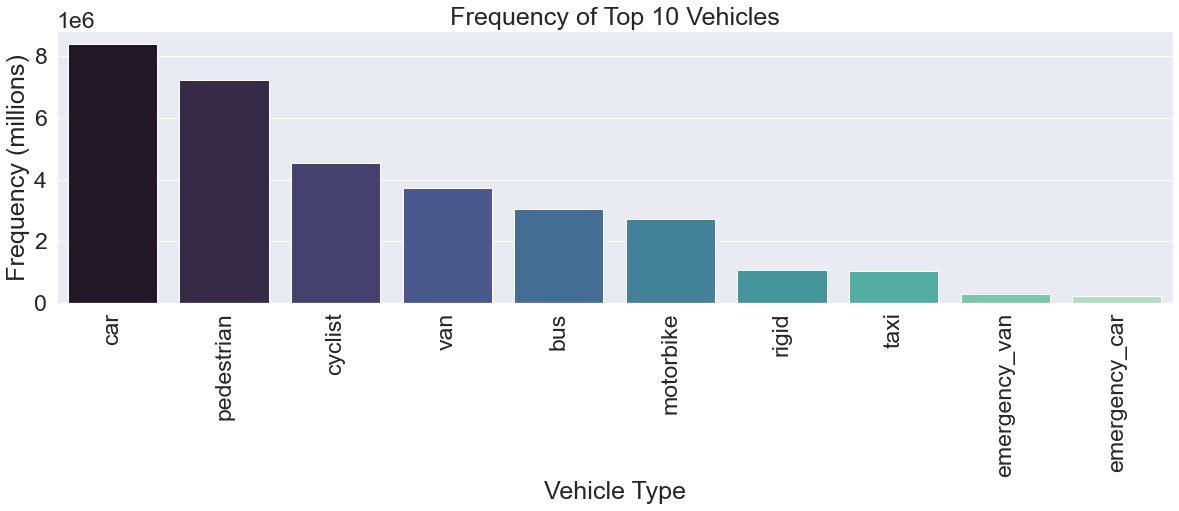

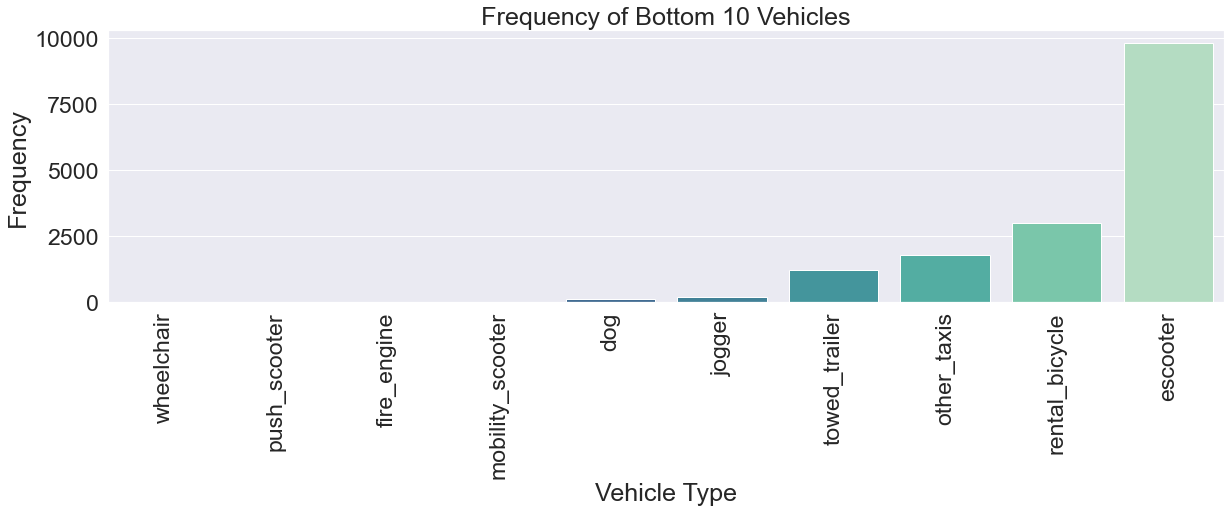

In [ ]:
sns.set_theme()
sns.set (font_scale=2.1)
plt.figure(figsize = (20,5))
plt.xticks(rotation=90)
sns.barplot(data =  subset_max, palette='mako', x='class', y='Number of Vehicles in')
plt.title('Frequency of Top 10 Vehicles')
plt.ylabel('Frequency (millions)')
plt.xlabel('Vehicle Type')

plt.figure(figsize = (20,5))
plt.xticks(rotation=90)
sns.barplot(data =  subset_min, palette='mako', x='class', y='Number of Vehicles in')
plt.title('Frequency of Bottom 10 Vehicles')
plt.ylabel('Frequency')
plt.xlabel('Vehicle Type')

In [ ]:
vehicle_in = vehicle_in_total[['Month_Label','Month','Year', 'class', 'Number of Vehicles in']].groupby(['Year','Month', 'Month_Label','class']).sum()
vehicle_in.reset_index(inplace=True)
#car_subset = car_subset.loc[car_subset['Year']==2021]

#df_wide = car_subset[['Number of Vehicles in', 'Month', 'class']].pivot("Month", "class", "Number of Vehicles in")
vehicle_in['Month/Year'] = vehicle_in['Month_Label'] +' ' +vehicle_in['Year'].astype(str)
vehicle_in_high = vehicle_in.merge(subset_one, how='inner', on='class')
vehicle_in_high.drop(['Number of Vehicles in_y', 'Number of Vehicles Out'], axis=1, inplace=True)

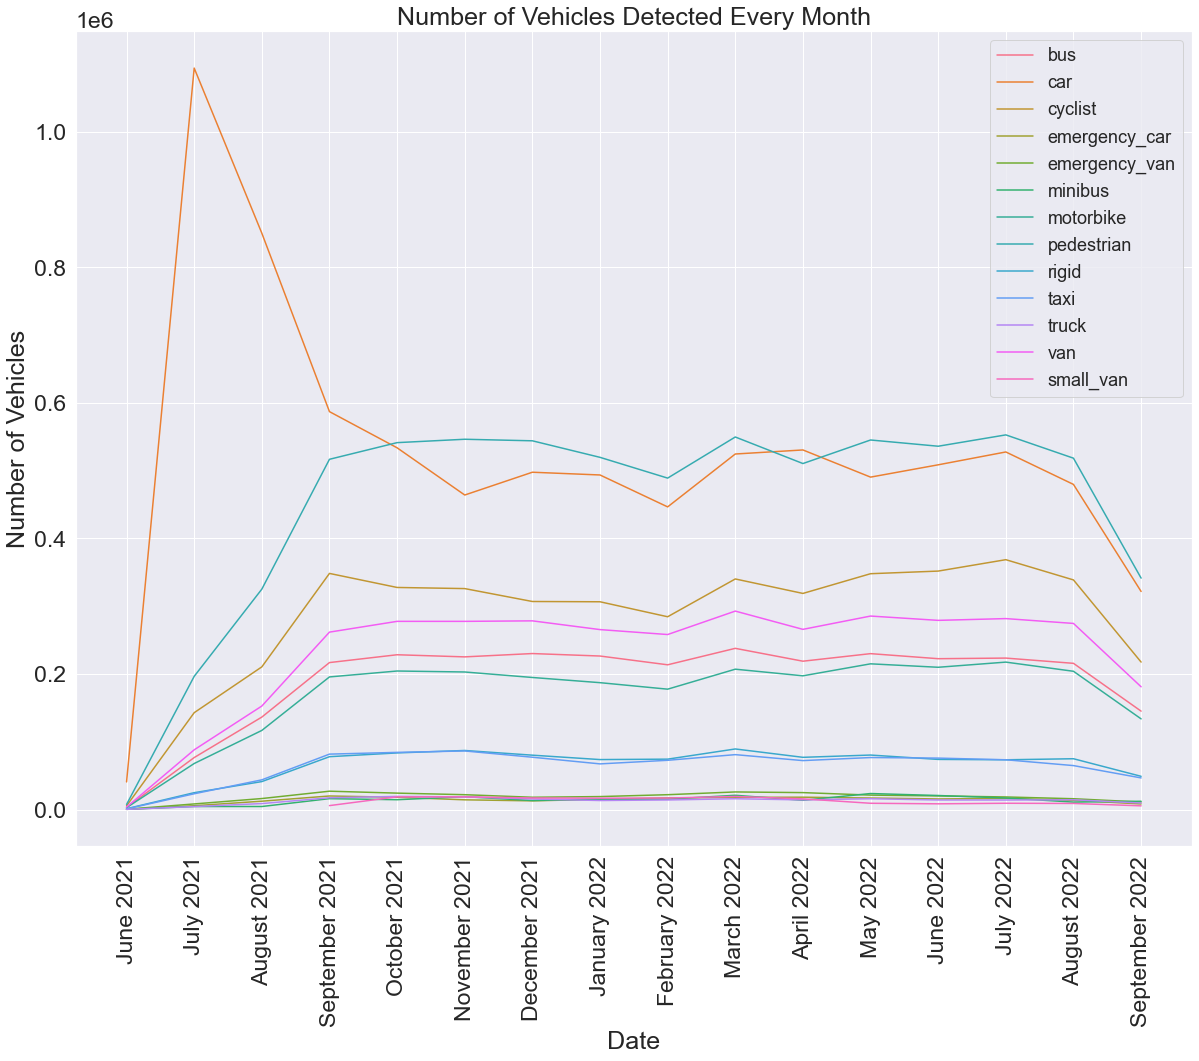

In [ ]:

plt.figure(figsize = (20,15))
sns.lineplot(data=vehicle_in_high, x = 'Month/Year', y='Number of Vehicles in_x', hue = 'class')
plt.title('Number of Vehicles Detected Every Month')
plt.xticks(rotation=90)

plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.legend(fontsize=18)

In [ ]:
vehicle_in_date = vehicle_in_total[['Day_of_Week', 'Day_Label', 'class', 'Number of Vehicles in', 'Year']].groupby(['Year','Day_of_Week', 'Day_Label','class']).sum()
vehicle_in_date.reset_index(inplace=True)
#car_subset = car_subset.loc[car_subset['Year']==2021]

#df_wide = car_subset[['Number of Vehicles in', 'Month', 'class']].pivot("Month", "class", "Number of Vehicles in")
vehicle_in_date['Day/Year'] =  vehicle_in_date['Day_Label']+' ' + vehicle_in_date['Year'].astype(str) 
#vehicle_in_high = vehicle_in.merge(subset_one, how='inner', on='class')
#vehicle_in_high.drop(['Number of Vehicles in_y', 'Number of Vehicles Out'], axis=1, inplace=True)

In [ ]:
#vehicle_in_date_2021 = vehicle_in_date.loc[vehicle_in_date['Year']==2021]
vehicle_in_date = vehicle_in_date.loc[(vehicle_in_date['class']=='car') | 
                         (vehicle_in_date['class']=='pedestrian') |
                        (vehicle_in_date['class']=='cyclist')|
                        (vehicle_in_date['class']=='van')|
                        (vehicle_in_date['class']=='bus')|
                        (vehicle_in_date['class']=='motorbike')|
                        (vehicle_in_date['class']=='rigid')|
                        (vehicle_in_date['class']=='taxi')|
                        (vehicle_in_date['class']=='emergency_van')|
                        (vehicle_in_date['class']=='london_bus')]

Text(0.5, 0, 'Weekday')

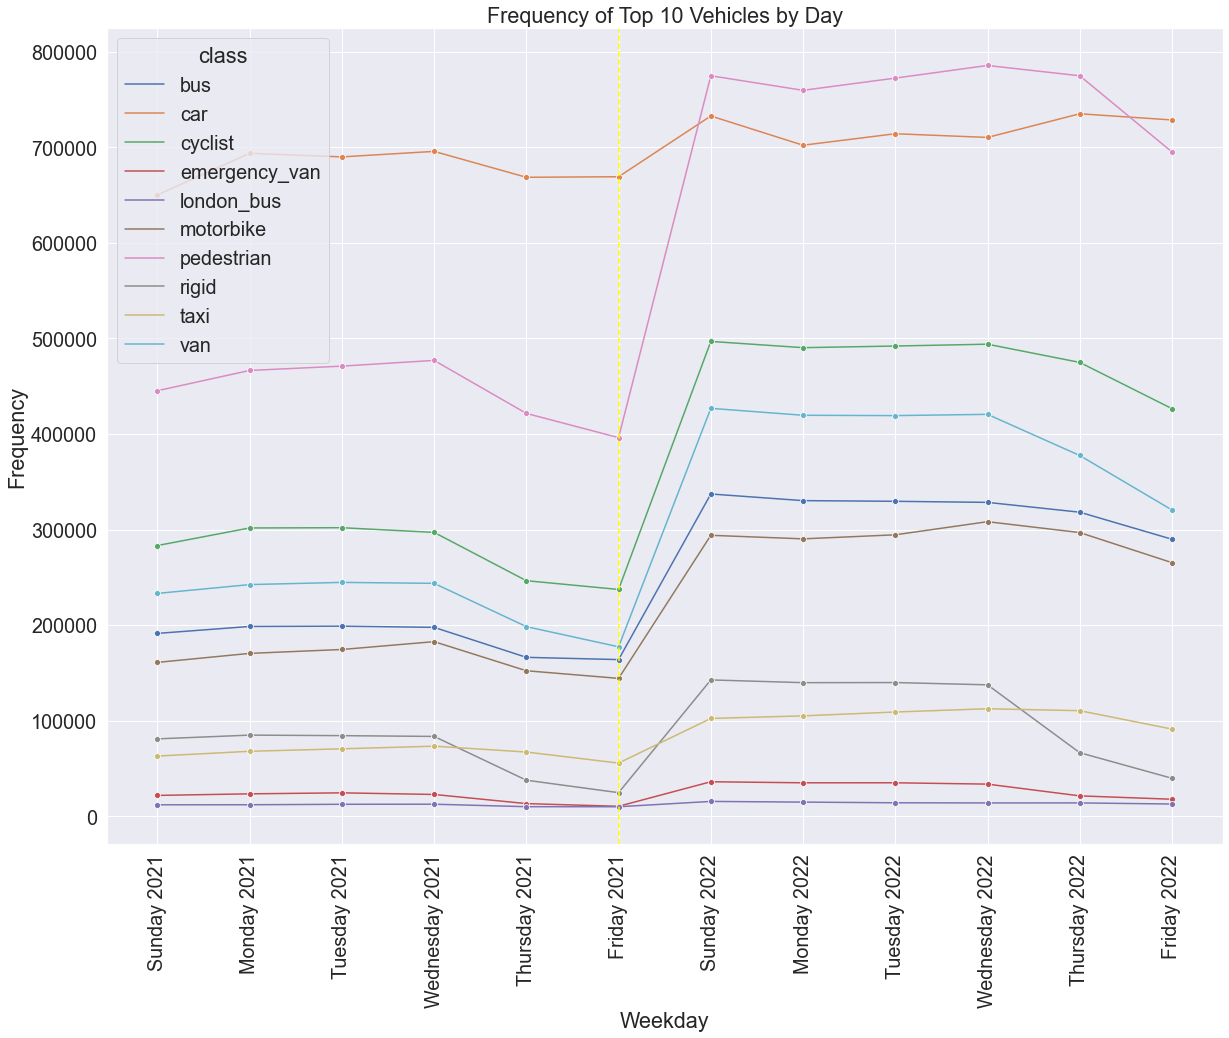

In [ ]:
sns.set_theme()
sns.set(font_scale=1.8
       )
plt.figure(figsize = (20,15))
plt.xticks(rotation=90)
sns.lineplot(data =  vehicle_in_date, x='Day/Year', y='Number of Vehicles in', hue='class',
            marker = 'o')
plt.axvline(color='yellow', x = 'Friday 2021', ymin=0, ymax = 700000, linestyle='--')
plt.title('Frequency of Top 10 Vehicles by Day')
plt.ylabel('Frequency')
plt.xlabel('Weekday')

Text(0.5, 0, 'Weekday')

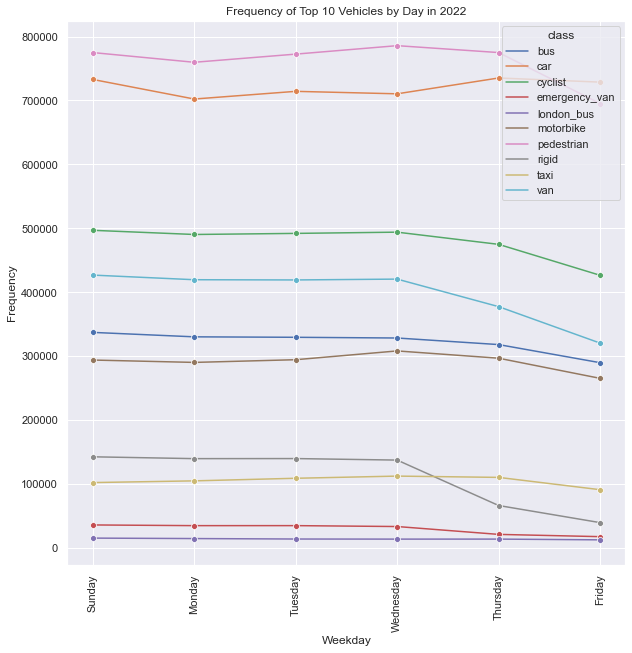

In [ ]:
vehicle_in_date_2022 = vehicle_in_date.loc[vehicle_in_date['Year']==2022]
vehicle_in_date_2022 = vehicle_in_date_2022.loc[(vehicle_in_date_2022['class']=='car') | 
                         (vehicle_in_date_2022['class']=='pedestrian') |
                        (vehicle_in_date_2022['class']=='cyclist')|
                        (vehicle_in_date_2022['class']=='van')|
                        (vehicle_in_date_2022['class']=='bus')|
                        (vehicle_in_date_2022['class']=='motorbike')|
                        (vehicle_in_date_2022['class']=='rigid')|
                        (vehicle_in_date_2022['class']=='taxi')|
                        (vehicle_in_date_2022['class']=='emergency_van')|
                        (vehicle_in_date_2022['class']=='london_bus')]

sns.set_theme()
plt.figure(figsize = (10,10))
plt.xticks(rotation=90)
sns.lineplot(data =  vehicle_in_date_2022, x='Day_Label', y='Number of Vehicles in', hue='class',
            marker = 'o')
plt.title('Frequency of Top 10 Vehicles by Day in 2022')
plt.ylabel('Frequency')
plt.xlabel('Weekday')

In [ ]:
sql = '''
SELECT TOP 15 * FROM traffic_sensors.Richmond_telemetry_distinct

'''
df = pd.read_sql(sql, cnxn)
df

,class,countIn,countOut,countline,from,to
0,car,0,0,25427,2021-06-30,2021-06-30 00:05:00
1,car,0,0,25426,2021-06-30,2021-06-30 00:05:00
2,car,0,0,25429,2021-06-30,2021-06-30 00:05:00
3,car,0,0,25428,2021-06-30,2021-06-30 00:05:00
4,car,0,0,25831,2021-06-30,2021-06-30 00:05:00
5,car,0,0,23960,2021-06-30,2021-06-30 00:05:00
6,bus,0,2,23246,2021-06-30,2021-06-30 00:05:00
7,car,1,4,23246,2021-06-30,2021-06-30 00:05:00
8,car,0,0,23402,2021-06-30,2021-06-30 00:05:00
9,bus,0,1,23165,2021-06-30,2021-06-30 00:05:00


In [ ]:
sql = '''
SELECT TOP 15 * FROM traffic_sensors.Richmond_CountlineMetadata
'''

df = pd.read_sql(sql, cnxn)
df

,id,name,deviceid,deviceuid,direction,latlong,latlongend,latlongstart,dir_in,dir_out,Notes
0,23139,S86_PetershamRd_path_RHS_slp001,86,0360ca10-b4b1-11eb-8574-42010af0092d,both,"(51.43933313340579,-0.30423597026892624)","(51.439335398883486,-0.3042529357149385)","(51.439331623087206,-0.30421779300603413)",Northbound,Southbound,None
1,23141,S87_HamGateAve_road_slp001,87,0360d442-b4b1-11eb-8574-42010af0092d,both,"(51.43210755866775,-0.29243219201220355)","(51.43208453562569,-0.29245271402924183)","(51.43213569792563,-0.29240551339129545)",Westbound,Eastbound,None
2,23960,RMD25_Hampton_Court_Rd_Road_s185,185,af6fb5e4-f446-11eb-8753-42010af0035d,both,"(51.41044665401297,-0.31379300437210916)","(51.41038642621619,-0.3137500997680968)","(51.41050018976492,-0.3138895397307044)",North east bound,South west bound,None
3,25831,RMD25_Hampton_Court_Rd_Path_S185,185,af6fb5e4-f446-11eb-8753-42010af0035d,both,"[51.410416229455926, -0.31416554597705654]","[51.41037739330011, -0.3141466012176948]","[51.41045675410459, -0.3141844907364183]",North east bound,South west bound,None
4,23987,RMD36_Hampton_Court_Rd_Road_s186,186,124e49c0-f44f-11eb-8208-42010af0035d,both,"(51.40610549716818,-0.34340725407424977)","(51.40607020076848,-0.3434638222448919)","(51.40614415509731,-0.34335337962663587)",North west bound,South east bound,None
5,23988,RMD36_Hampton_Court_Rd_Path_RHS_s186,186,124e49c0-f44f-11eb-8208-42010af0035d,both,"(51.4060617968605,-0.3434799845790667)","(51.40605171216817,-0.34350153435830566)","(51.40607020076848,-0.3434638222448919)",North west bound,South east bound,None
6,25751,RMD26_Hampton_Court_Rd_Path_LHS_s186,186,124e49c0-f44f-11eb-8208-42010af0035d,both,"[51.40615423976921, -0.34333721729243566]","[51.40614415509731, -0.34335337962663587]","[51.40616768599503, -0.34332105495823545]",North west bound,South east bound,None
7,23984,RMD27_Church_St_Path_S187,187,124e41a0-f44f-11eb-8208-42010af0035d,both,"(51.41319141144628,-0.360252259185749)","(51.41317802830137,-0.36027907456351116)","(51.41317468251542,-0.3602254438079868)",Northbound,Southbound,None
8,23985,RMD27_Church_St_Road_S187,187,124e41a0-f44f-11eb-8208-42010af0035d,both,"(51.41314122463417,-0.3603273422432795)","(51.41315460778986,-0.3604131514513297)","(51.41317802830137,-0.36027907456351116)",Northbound,Southbound,None
9,23966,RMD28_Park_Rd_PathLHS_S188,188,124e24a4-f44f-11eb-8208-42010af0035d,both,"(51.42923,-0.35473)","(51.429172,-0.354869)","(51.429138,-0.354876)",Eastbound,Westbound,None


In [ ]:
sql = '''
SELECT COUNT (DISTINCT id) FROM traffic_sensors.Richmond_CountlineMetadata
'''

countline_total = pd.read_sql(sql, cnxn)
print('There are a total of ', countline_total, ' directions in which vehicles are being counted.')

sql = '''
SELECT COUNT (DISTINCT deviceid) FROM traffic_sensors.Richmond_CountlineMetadata
'''

device_total = pd.read_sql(sql, cnxn)
print('There are a total of ', device_total, ' devices currently deployed.')


sql = '''
SELECT COUNT (DISTINCT name) FROM traffic_sensors.Richmond_CountlineMetadata
'''

road_total = pd.read_sql(sql, cnxn)
print('There are a total of ', road_total, ' roads with sensors.')


There are a total of        
0  168  directions in which vehicles are being counted.
There are a total of       
0  61  devices currently deployed.
There are a total of        
0  168  roads with sensors.


In [ ]:
sql = '''
SELECT direction, COUNT(*) AS count 
FROM traffic_sensors.Richmond_CountlineMetadata 
GROUP BY direction
'''

direction_unique = pd.read_sql(sql, cnxn)



In [ ]:
sql = '''
SELECT *
FROM traffic_sensors.Richmond_CountlineMetadata 
WHERE direction = 'clockwise' OR direction ='anti-clockwise' 
OR deviceid = 197 OR deviceid = 218 OR deviceid = 70 OR deviceid = 88
'''

diff_directions = pd.read_sql(sql, cnxn)
diff_directions.to_csv('abnormal_devices.csv')


In [ ]:
df.columns

Index(['id', 'name', 'deviceid', 'deviceuid', 'direction', 'latlong',
       'latlongend', 'latlongstart', 'dir_in', 'dir_out', 'Notes'],
      dtype='object')

In [ ]:
sql = '''
SELECT COUNT(traffic_sensors.Richmond_telemetry_distinct.countin) AS 'Number of Vehicles in', 
traffic_sensors.Richmond_telemetry_distinct.countline,
traffic_sensors.Richmond_CountlineMetadata.name,
traffic_sensors.Richmond_CountlineMetadata.latlong


FROM traffic_sensors.Richmond_telemetry_distinct 
INNER JOIN traffic_sensors.Richmond_CountlineMetadata ON 
traffic_sensors.Richmond_CountlineMetadata.id = traffic_sensors.Richmond_telemetry_distinct.countline
GROUP BY traffic_sensors.Richmond_telemetry_distinct.countline,
traffic_sensors.Richmond_CountlineMetadata.name,
traffic_sensors.Richmond_CountlineMetadata.latlong
'''

count_by_loc = pd.read_sql(sql, cnxn)


In [ ]:
na_loclist = list(count_by_loc.loc[count_by_loc['latlong']=='N/A']['countline'])

In [ ]:
count_by_loc['countline'] = count_by_loc['countline'].astype(int)

In [ ]:
sql = '''
SELECT * FROM traffic_sensors.Richmond_CountlineMetadata WHERE
traffic_sensors.Richmond_CountlineMetadata.id= 40273 OR
traffic_sensors.Richmond_CountlineMetadata.id= 40272 OR
traffic_sensors.Richmond_CountlineMetadata.id= 40271 OR
traffic_sensors.Richmond_CountlineMetadata.id= 40270 OR
traffic_sensors.Richmond_CountlineMetadata.id= 40269 OR
traffic_sensors.Richmond_CountlineMetadata.id= 40268 OR
traffic_sensors.Richmond_CountlineMetadata.id= 40264 OR
traffic_sensors.Richmond_CountlineMetadata.id= 40263 OR
traffic_sensors.Richmond_CountlineMetadata.id= 40262 

'''

NA_loc = pd.read_sql(sql, cnxn)


In [ ]:
count_locations = count_by_loc.merge(NA_loc[['id', 'latlongend']], how='outer', 
                                  left_on='countline', right_on='id')
        

In [ ]:
count_locations.drop('id', axis=1, inplace=True)

In [ ]:
count_locations[['Lat', 'Long']] = count_locations['latlong'].str.split(',', expand=True)

In [ ]:
count_locations[['Lat_x', 'Lat']] =count_locations['Lat'].str.split('(', expand=True)


In [ ]:
count_locations[['Long', 'Long_x']] =count_locations['Long'].str.split(')', expand=True)

In [ ]:
count_locations.drop(['Lat_x', 'Long_x'], axis=1, inplace=True)

In [ ]:
count_locations

,Number of Vehicles in,countline,name,latlong,latlongend,Lat,Long
0,567421,23116,RMD1_HamptonCtBridge_road_RHS_s70,"(51.404245227396785,-0.3421240223429191)",NaN,51.404245227396785,-0.3421240223429191
1,165450,23117,RMD1_HamptonCtBridge_path_RHS_s70,"(51.404255266716646,-0.34220718221164015)",NaN,51.404255266716646,-0.34220718221164015
2,193898,23118,RMD4_BurtonsRd_road_s73,"(51.43090026781854,-0.3568549558529442)",NaN,51.43090026781854,-0.3568549558529442
3,680918,23119,RMD2_HighSt_road_s71,"(51.42585208751514,-0.3568947521521114)",NaN,51.42585208751514,-0.3568947521521114
4,119011,23120,RMD2_HighSt_path_LHS_s71,"(51.4258821912361,-0.35695376074981655)",NaN,51.4258821912361,-0.35695376074981655
...,...,...,...,...,...,...,...
163,98621,40269,RMD61_kewRd_path_RHS_S265,N/A,"[-0.287711,51.481865]",None,None
164,451617,40270,RMD61_kewRd_road_S265,N/A,"[-0.287731,51.481869]",None,None
165,68526,40271,RMD62_highParkRd_path_LHS_S266,N/A,"[-0.285725,51.476055]",None,None
166,82555,40272,RMD62_highParkRd_path_RHS_S266,N/A,"[-0.285674,51.476135]",None,None


In [ ]:
count_locations[['Latend', 'Longend']] = count_locations['latlongend'].str.split(',', expand=True)
count_locations[['Latend_x', 'Latend']] =count_locations['Latend'].str.split('[', expand=True)


In [ ]:
count_locations[['Longend', 'Longend_x']] =count_locations['Longend'].str.split(']', expand=True)

In [ ]:
count_locations.drop(['Latend_x', 'Longend_x', 'latlongend'], axis=1, inplace=True)

In [ ]:
for i in range(len(count_locations)):
    if count_locations.iloc[i,3]=='N/A':
        count_locations.iloc[i,4] = count_locations.iloc[i,6]
        count_locations.iloc[i,5] = count_locations.iloc[i,7]

In [ ]:
count_locations.drop(['Latend', 'Longend', 'latlong'], axis=1, inplace=True)

In [ ]:
sql = '''
SELECT id, deviceid, dir_in, dir_out FROM traffic_sensors.Richmond_CountlineMetadata 

'''

metadata = pd.read_sql(sql, cnxn)


In [ ]:
count_locations_merged = count_locations.merge(metadata, how='inner', left_on='countline',
                                       right_on = 'id')

In [ ]:
count_locations_merged.drop('id', axis=1, inplace=True)

In [ ]:
subset = count_locations_merged[['Number of Vehicles in', 'name', 'Lat', 'Long']]


Text(0.5, 0, 'Vehicle Type')

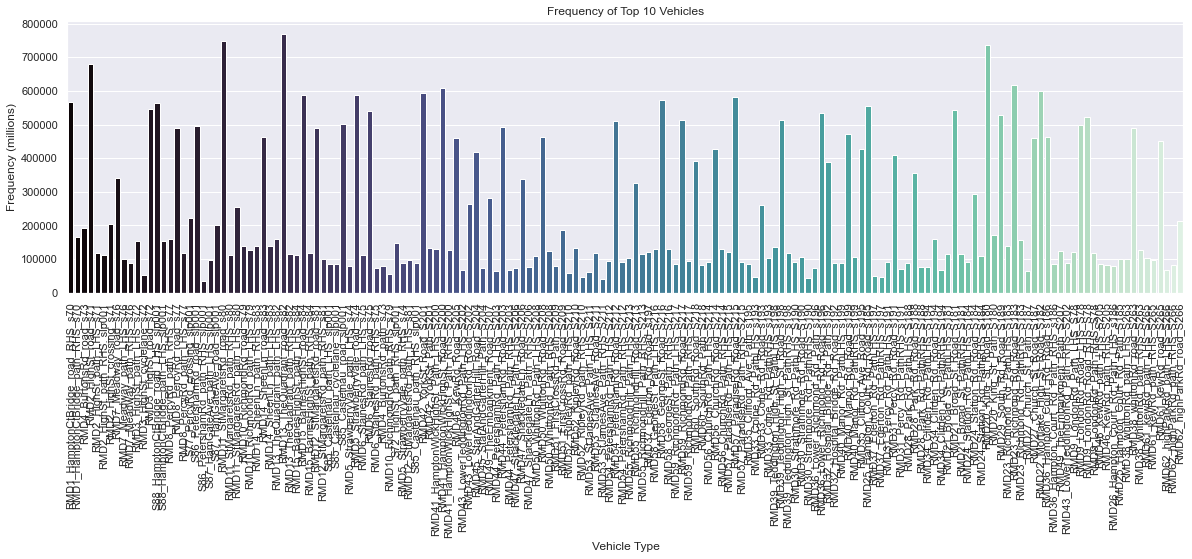

In [ ]:
sns.set_theme()
plt.figure(figsize = (20,5))
plt.xticks(rotation=90)
sns.barplot(data =  count_locations_merged, palette='mako', x='name', y='Number of Vehicles in')
plt.title('Frequency of Top 10 Vehicles')
plt.ylabel('Frequency (millions)')
plt.xlabel('Vehicle Type')

In [ ]:
subset.describe()

,Number of Vehicles in
count,168.000000
mean,227081.577381
std,193682.253118
min,35705.000000
25%,89044.500000
50%,122311.500000
75%,395748.500000
max,769201.000000


In [ ]:
location_counts = pd.read_csv('count_locations.csv')

In [ ]:
import branca.colormap as cm


#zooms in at richmond as a starting point
rich_map = folium.Map(location=[51.47, -.4], zoom_start=11.3, control_scale=True)

colormap = cm.StepColormap(colors=['green','yellow','orange','red'] ,#renkler
                           index=[32155,81266,113806,374998,700897], #eşik değerler
                           vmin= 32155,
                           vmax=700897)
for loc, p, n in zip(zip(location_counts["Lat"],location_counts["Long"]),location_counts["Number of Vehicles in"],
                    location_counts["name"]):
      folium.Circle(
      location=loc,
      radius=4, 
      fill=True, 
      color=colormap(p),
          popup = (p,n) 
).add_to(rich_map)


In [ ]:
rich_map.save('Total_Vehicles.html')

In [ ]:
rich_map

In [ ]:
location_counts.nsmallest(10, 'Number of Vehicles in').to_csv('least_busiest_loc.csv')

In [ ]:
sql = '''
SELECT COUNT(traffic_sensors.Richmond_telemetry_distinct.countin) AS 'Number of Vehicles in', 
traffic_sensors.Richmond_telemetry_distinct.countline,
traffic_sensors.Richmond_CountlineMetadata.name,
traffic_sensors.Richmond_CountlineMetadata.latlong,
traffic_sensors.Richmond_telemetry_distinct.[from]

FROM traffic_sensors.Richmond_telemetry_distinct 
INNER JOIN traffic_sensors.Richmond_CountlineMetadata ON 
traffic_sensors.Richmond_CountlineMetadata.id = traffic_sensors.Richmond_telemetry_distinct.countline


GROUP BY traffic_sensors.Richmond_telemetry_distinct.countline,
traffic_sensors.Richmond_CountlineMetadata.name,
traffic_sensors.Richmond_CountlineMetadata.latlong,
traffic_sensors.Richmond_telemetry_distinct.[from] 
'''
count_by_loc_date = pd.read_sql(sql, cnxn)


In [ ]:
count_by_loc_2021 = count_by_loc_date.loc[count_by_loc_date['from']<'2022-01-01']

In [ ]:
count_by_loc_2021['countline'] = count_by_loc_2021['countline'].astype(int)

<ipython-input-54-d7eec36c42d2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_by_loc_2021['countline'] = count_by_loc_2021['countline'].astype(int)


In [ ]:
count_by_loc_2021_cleaned = count_by_loc_2021.merge(location_counts, how='inner', on='countline')

In [ ]:
count_by_loc_2021_cleaned.drop(['name_y', 'latlong', 'Number of Vehicles in_y', 'Column1'], axis=1,
                              inplace=True)

In [ ]:
vehicle_counts_2021 = count_by_loc_2021_cleaned.groupby(['countline', 'name_x', 'Lat', 'Long']).sum().reset_index()

In [ ]:
vehicle_counts_2021

,countline,name_x,Lat,Long,Number of Vehicles in_x
0,23116,RMD1_HamptonCtBridge_road_RHS_s70,51.404245,-0.342124,233470
1,23117,RMD1_HamptonCtBridge_path_RHS_s70,51.404255,-0.342207,84497
2,23118,RMD4_BurtonsRd_road_s73,51.430900,-0.356855,86341
3,23119,RMD2_HighSt_road_s71,51.425852,-0.356895,267113
4,23120,RMD2_HighSt_path_LHS_s71,51.425882,-0.356954,49208
...,...,...,...,...,...
163,40269,RMD61_kewRd_path_RHS_S265,51.481865,-0.287711,44870
164,40270,RMD61_kewRd_road_S265,51.481869,-0.287731,129530
165,40271,RMD62_highParkRd_path_LHS_S266,51.476055,-0.285725,38163
166,40272,RMD62_highParkRd_path_RHS_S266,51.476135,-0.285674,41327


In [ ]:
vehicle_counts_2022 = vehicle_counts_2021.copy()

In [ ]:
vehicle_counts_2022['Number of Vehicles in_x'] = location_counts['Number of Vehicles in'] - vehicle_counts_2021['Number of Vehicles in_x']

In [ ]:
vehicle_counts_2022

,countline,name_x,Lat,Long,Number of Vehicles in_x
0,23116,RMD1_HamptonCtBridge_road_RHS_s70,51.404245,-0.342124,281656
1,23117,RMD1_HamptonCtBridge_path_RHS_s70,51.404255,-0.342207,64487
2,23118,RMD4_BurtonsRd_road_s73,51.430900,-0.356855,91478
3,23119,RMD2_HighSt_road_s71,51.425852,-0.356895,347083
4,23120,RMD2_HighSt_path_LHS_s71,51.425882,-0.356954,58474
...,...,...,...,...,...
163,40269,RMD61_kewRd_path_RHS_S265,51.481865,-0.287711,44369
164,40270,RMD61_kewRd_road_S265,51.481869,-0.287731,264175
165,40271,RMD62_highParkRd_path_LHS_S266,51.476055,-0.285725,25013
166,40272,RMD62_highParkRd_path_RHS_S266,51.476135,-0.285674,34222


In [ ]:
vehicle_counts_2022


,countline,name_x,Lat,Long,Number of Vehicles in_x
0,23116,RMD1_HamptonCtBridge_road_RHS_s70,51.404245,-0.342124,281656
1,23117,RMD1_HamptonCtBridge_path_RHS_s70,51.404255,-0.342207,64487
2,23118,RMD4_BurtonsRd_road_s73,51.430900,-0.356855,91478
3,23119,RMD2_HighSt_road_s71,51.425852,-0.356895,347083
4,23120,RMD2_HighSt_path_LHS_s71,51.425882,-0.356954,58474
...,...,...,...,...,...
163,40269,RMD61_kewRd_path_RHS_S265,51.481865,-0.287711,44369
164,40270,RMD61_kewRd_road_S265,51.481869,-0.287731,264175
165,40271,RMD62_highParkRd_path_LHS_S266,51.476055,-0.285725,25013
166,40272,RMD62_highParkRd_path_RHS_S266,51.476135,-0.285674,34222


In [ ]:
import branca.colormap as cm

#opening the map file
with open('36600.geojson') as f:
    laArea = json.load(f)

#zooms in at north england as a starting point
laMap = folium.Map(location=[51.47, -.4], zoom_start=11.3, control_scale=True)

colormap = cm.StepColormap(colors=['green','yellow','orange','red'] ,#renkler
                           index=[14045.000000,41778,59514,210486,401215], #eşik değerler
                           vmin= 14045,
                           vmax=401215)
for loc, p, n in zip(zip(vehicle_counts_2021["Lat"],vehicle_counts_2021["Long"]),
                     vehicle_counts_2021["Number of Vehicles in_x"],
                    vehicle_counts_2021["name_x"]):
      folium.Circle(
      location=loc,
      radius=4, 
      fill=True, 
      color=colormap(p),
          popup = (p,n)
).add_to(laMap)


In [ ]:
laMap.save('Total Vehicles 2021 final.html')

In [ ]:
sql = '''
SELECT COUNT(traffic_sensors.Richmond_telemetry_distinct.countin) AS 'Number of Vehicles in', 
traffic_sensors.Richmond_telemetry_distinct.countline,
traffic_sensors.Richmond_CountlineMetadata.name,
traffic_sensors.Richmond_CountlineMetadata.latlong,
traffic_sensors.Richmond_CountlineMetadata.dir_in,
traffic_sensors.Richmond_CountlineMetadata.dir_out,
traffic_sensors.Richmond_CountlineMetadata.deviceid



FROM traffic_sensors.Richmond_telemetry_distinct 
INNER JOIN traffic_sensors.Richmond_CountlineMetadata ON 
traffic_sensors.Richmond_CountlineMetadata.id = traffic_sensors.Richmond_telemetry_distinct.countline


GROUP BY traffic_sensors.Richmond_telemetry_distinct.countline,
traffic_sensors.Richmond_CountlineMetadata.name,
traffic_sensors.Richmond_CountlineMetadata.latlong,
traffic_sensors.Richmond_CountlineMetadata.dir_in,
traffic_sensors.Richmond_CountlineMetadata.dir_out,
traffic_sensors.Richmond_CountlineMetadata.deviceid

'''
direction_count = pd.read_sql(sql, cnxn)


In [ ]:
direction_count['countline'] = direction_count['countline'].astype(int)

In [ ]:
cleaned_directions = direction_count.merge(location_counts, how='inner', on='countline')

In [ ]:
cleaned_directions.drop(['latlong', 'Column1', 'Number of Vehicles in_y', 'name_y'], axis=1,
                       inplace=True)

In [ ]:
cleaned_directions['dir_in'] = cleaned_directions['dir_in'].str.lower()
cleaned_directions['dir_out'] = cleaned_directions['dir_out'].str.lower()
cleaned_directions['dir_in'] = cleaned_directions['dir_in'].str.replace(' ', '')
cleaned_directions['dir_out'] = cleaned_directions['dir_out'].str.replace(' ', '')


In [ ]:
cleaned_directions['direction'] = cleaned_directions['dir_in'] +'/'+ cleaned_directions['dir_out']

In [ ]:
cleaned_directions

,Number of Vehicles in_x,countline,name_x,dir_in,dir_out,deviceid,Lat,Long,direction
0,567421,23116,RMD1_HamptonCtBridge_road_RHS_s70,northbound,southbound,70,51.404245,-0.342124,northbound/southbound
1,165450,23117,RMD1_HamptonCtBridge_path_RHS_s70,northbound,southbound,70,51.404255,-0.342207,northbound/southbound
2,193898,23118,RMD4_BurtonsRd_road_s73,southeastbound,northwestbound,73,51.430900,-0.356855,southeastbound/northwestbound
3,680918,23119,RMD2_HighSt_road_s71,southbound,northbound,71,51.425852,-0.356895,southbound/northbound
4,119011,23120,RMD2_HighSt_path_LHS_s71,southbound,northbound,71,51.425882,-0.356954,southbound/northbound
...,...,...,...,...,...,...,...,...,...
163,98621,40269,RMD61_kewRd_path_RHS_S265,northbound,southbound,265,51.481865,-0.287711,northbound/southbound
164,451617,40270,RMD61_kewRd_road_S265,northbound,southbound,265,51.481869,-0.287731,northbound/southbound
165,68526,40271,RMD62_highParkRd_path_LHS_S266,eastbound,westbound,266,51.476055,-0.285725,eastbound/westbound
166,82555,40272,RMD62_highParkRd_path_RHS_S266,westbound,eastbound,266,51.476135,-0.285674,westbound/eastbound


In [ ]:
cleaned_directions['direction'].unique()

array(['northbound/southbound', 'southeastbound/northwestbound',
       'southbound/northbound', 'eastbound/westbound',
       'northeastbound/southwestbound', 'westbound/eastbound',
       'southwestbound/northeastbound', 'northwestbound/southeastbound'],
      dtype=object)

Text(0.5, 0, 'Vehicle Type')

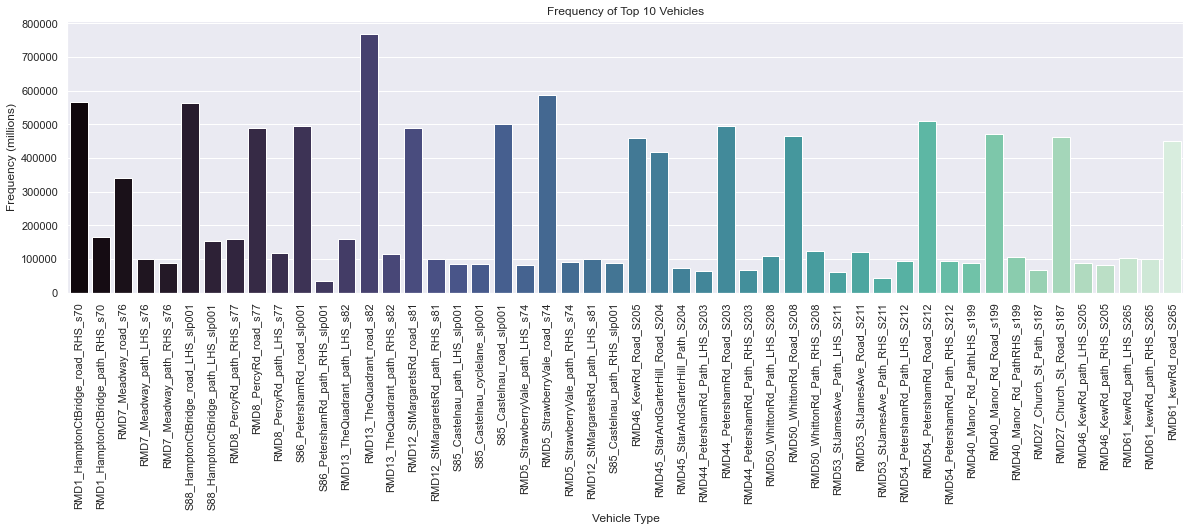

In [ ]:
sns.set_theme()
plt.figure(figsize = (20,5))
plt.xticks(rotation=90)
sns.barplot(data =  cleaned_directions.loc[cleaned_directions['direction']=='northbound/southbound'], palette='mako', x='name_x', y='Number of Vehicles in_x')
plt.title('Frequency of Top 10 Vehicles')
plt.ylabel('Frequency (millions)')
plt.xlabel('Vehicle Type')

Text(0.5, 0, 'Direction')

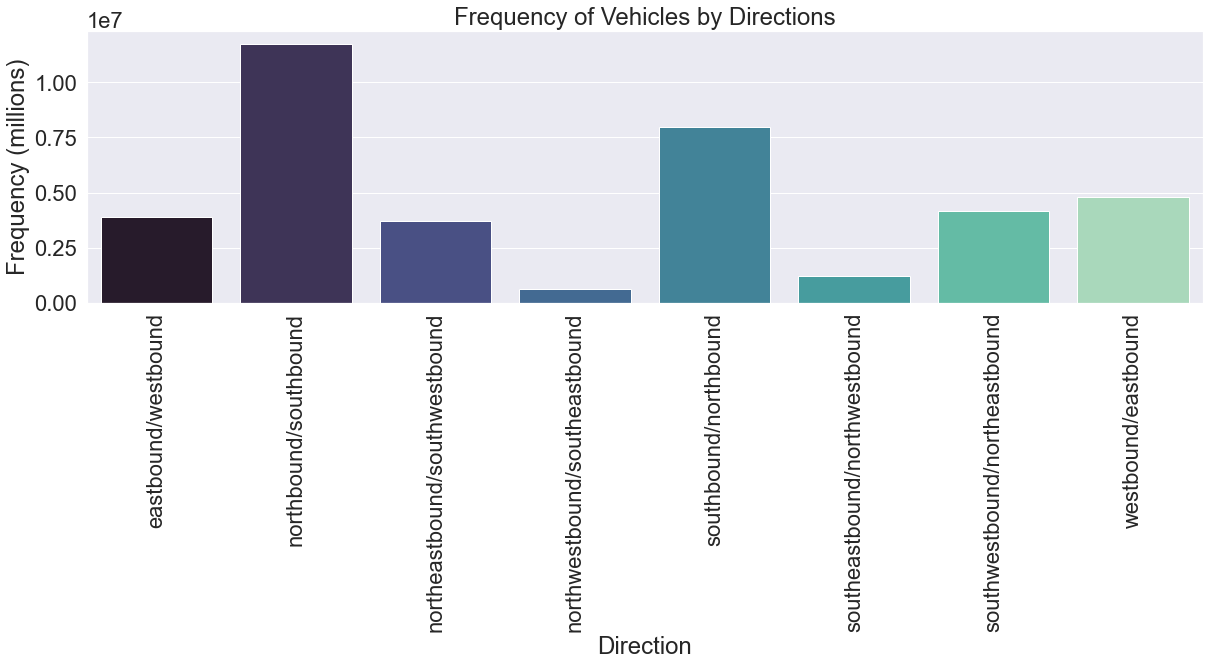

In [ ]:
sns.set_theme()
sns.set (font_scale=2)
plt.figure(figsize = (20,5))
plt.xticks(rotation=90)
sns.barplot(data =  cleaned_directions.groupby(['direction']).sum().reset_index(), palette='mako', x='direction', y='Number of Vehicles in_x')
plt.title('Frequency of Vehicles by Directions')
plt.ylabel('Frequency (millions)')
plt.xlabel('Direction')

In [ ]:
cleaned_directions.groupby(['direction']).sum()

,Number of Vehicles in_x,countline,deviceid,Lat,Long
direction,,,,,
eastbound/westbound,3886758,444301,3176,926.046921,-5.709796
northbound/southbound,11740428,1230289,7289,2572.409399,-15.837084
northeastbound/southwestbound,3730070,334084,2242,720.116879,-4.647116
northwestbound/southeastbound,628250,73726,558,154.218322,-1.030224
southbound/northbound,7970342,885483,5665,1800.472877,-11.477340
southeastbound/northwestbound,1226707,189981,1364,411.564852,-2.643249
southwestbound/northeastbound,4169226,450593,3045,977.527459,-6.179347
westbound/eastbound,4797924,533159,3892,1080.323988,-6.718506


In [ ]:
vehicle_counts_2021['Number of Vehicles in_x'].sum()

15113830